In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [2]:
api_key = '6feb8c26f0ebddbc4a47b6cfeac77054'
url = f'https://api.stlouisfed.org/fred/series/observations?series_id=LRUNTTTTCLM156N&api_key={api_key}&observation_start=1980-01-01&observation_end=2022-12-01&frequency=m&file_type=json'
response = requests.get(url)

In [3]:
json_data = response.json()

In [4]:
data = [(obs["date"], obs["value"]) for obs in json_data["observations"]]
df = pd.DataFrame(data, columns=["date", "Unemployment Rate Chile"])
df["date"] = pd.to_datetime(df["date"])
df["Unemployment Rate Chile"] = df["Unemployment Rate Chile"].astype("float")
df.index = df["date"]
df = df.drop("date", axis = 1)
df.dropna()
df

,Unemployment Rate Chile
date,
1986-01-01,13.540000
1986-02-01,13.350000
1986-03-01,12.660000
1986-04-01,12.540000
1986-05-01,12.570000
...,...
2022-08-01,8.040024
2022-09-01,7.968381
2022-10-01,7.948823


In [5]:
df.index.freq = "MS"

Text(0, 0.5, 'Unemployment Rate (Percentage Older than 15)')

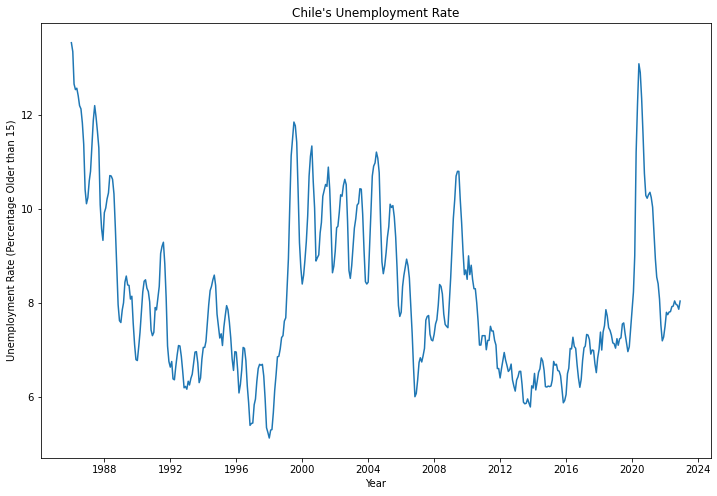

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(df['Unemployment Rate Chile'])
plt.title("Chile's Unemployment Rate")
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (Percentage Older than 15)')

In [7]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [8]:
adf_test(df['Unemployment Rate Chile'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.534596
p-value                   0.007142
# lags used              13.000000
# observations          430.000000
critical value (1%)      -3.445649
critical value (5%)      -2.868285
critical value (10%)     -2.570363
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [9]:
len(df)

444

In [10]:
q_80 = int(len(df) * .8)

In [11]:
y_train = df["Unemployment Rate Chile"].iloc[:q_80]
y_test = df["Unemployment Rate Chile"].iloc[q_80:]

<AxesSubplot:xlabel='date'>

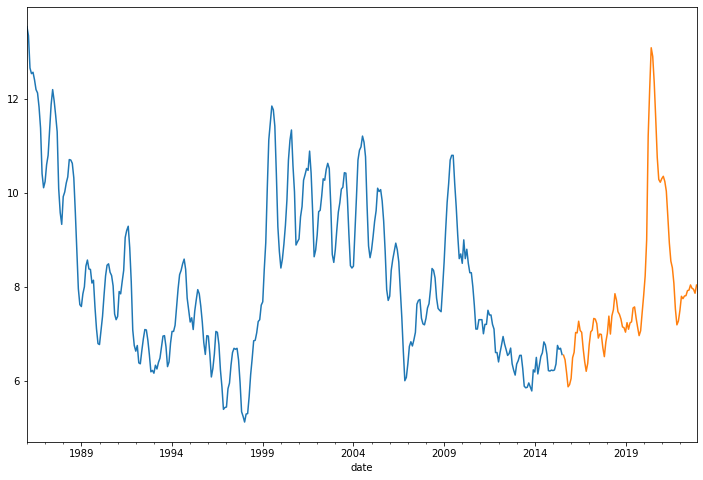

In [12]:
y_train.plot(figsize = (12, 8))
y_test.plot()

In [13]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
model = auto_arima(y_train, trace = True, seasonal = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-60.572, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=325.754, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=82.299, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=165.283, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=324.701, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=25.711, Time=0.50 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-3.377, Time=0.51 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-57.133, Time=1.86 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-57.974, Time=1.76 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=61.274, Time=0.19 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2.494, Time=1.03 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-32.004, Time=1.50 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-57.324, Time=1.91 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-61.049, Time=0.72 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : 

Potential models are: 
- ARIMA(0,1,3)x(1,0,1,12)
- ARIMA(1,1,2)x(1,0,1,12)
- ARIMA(0,1,4)x(1,0,1,12)
- ARIMA(0,1,3)x(2,0,2,12)

In [15]:
model_list = {"order": [(0, 1, 3), (1, 1, 2), (0, 1 ,4), (0, 1 ,3)], "seasonal_order": [(1,0,1,12), (1,0,1,12), (1,0,1,12), (2,0,2,12)]}

In [16]:
from statsmodels.tools.eval_measures import rmse

In [17]:
metrics = pd.DataFrame(data = {"Order" : [], "Seasonal Order": [], "AIC": [], "BIC" : [], "RMSE": []})
for order, seasonal_order in zip(model_list["order"], model_list["seasonal_order"]):
    model= SARIMAX(y_train, order = order, seasonal_order = seasonal_order, enforce_invertibility = True).fit()
   
    start = len(y_train)
    end = len(y_train) + len(y_test) -1
    
    y_pred = model.predict(start, end)
    rmse_model = rmse(y_test, y_pred)
    
    metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": model.aic, "BIC" : model.bic, "RMSE": rmse_model}, ignore_index = True)

C:\Users\User\AppData\Local\Temp\ipykernel_15896\500163460.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": model.aic, "BIC" : model.bic, "RMSE": rmse_model}, ignore_index = True)
C:\Users\User\AppData\Local\Temp\ipykernel_15896\500163460.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": model.aic, "BIC" : model.bic, "RMSE": rmse_model}, ignore_index = True)
C:\Users\User\AppData\Local\Temp\ipykernel_15896\500163460.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": m

In [18]:
metrics = metrics.sort_values("RMSE")
metrics

,Order,Seasonal Order,AIC,BIC,RMSE
3,"(0, 1, 3)","(2, 0, 2, 12)",-60.218889,-29.264514,2.823396
2,"(0, 1, 4)","(1, 0, 1, 12)",-61.947258,-34.862180,2.842501
0,"(0, 1, 3)","(1, 0, 1, 12)",-62.866671,-39.650890,2.850705
1,"(1, 1, 2)","(1, 0, 1, 12)",-62.853110,-39.637329,2.852224


The best model is SARIMA(0,1,3)x(2,0,2,12)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='date'>

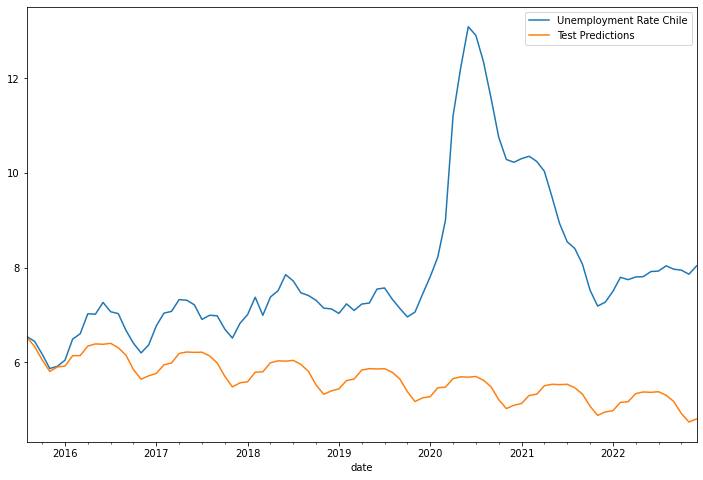

In [19]:
selected_model = SARIMAX(y_train, order = metrics["Order"].iloc[0], seasonal_order = metrics["Seasonal Order"].iloc[0], enforce_invertibility = True).fit()
y_hat_test = selected_model.predict(start, end).rename("Test Predictions")
plt.figure(figsize = (12, 8))
y_test.plot(legend = True)
y_hat_test.plot(legend = True)

In [20]:
final_model =  SARIMAX(df["Unemployment Rate Chile"], order = metrics["Order"].iloc[0], seasonal_order = metrics["Seasonal Order"].iloc[0], enforce_invertibility = True).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                 Unemployment Rate Chile   No. Observations:                  444
Model:             SARIMAX(0, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood                  29.318
Date:                                 Fri, 02 Jun 2023   AIC                            -42.635
Time:                                         01:14:08   BIC                             -9.887
Sample:                                     01-01-1986   HQIC                           -29.720
                                          - 12-01-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6400      0.038     16.914      0.000       0.566       0.714
ma.L2          0.5662      0.046     12.237      0.000       0.476       0.657
ma.L3         -0.1056      0.042     -2.506      0.012      -0.188      -0.023
ar.S.L12       0.1558      0.289      0.539      0.590      -0.410       0.722
ar.S.L24       0.8133      0.287      2.836      0.005       0.251       1.375
ma.S.L12      -0.0682      0.305     -0.223      0.823      -0.666       0.530
ma.S.L24      -0.6775      0.276     -2.451      0.014      -1.219      -0.136
sigma2         0.0497      0.002     20.411      0.000       0.045       0.055
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               364.24
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.47
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
forecast_size = 12

In [22]:
final_order  = metrics["Order"].iloc[0]
final_seasonal_order = metrics["Seasonal Order"].iloc[0]

In [23]:
y_forecast = final_model.predict(start = len(df), end = len(df) + forecast_size - 1, typ = "levels").rename(f"SARIMA{final_order}x{final_seasonal_order} Forecast")

<AxesSubplot:xlabel='date'>

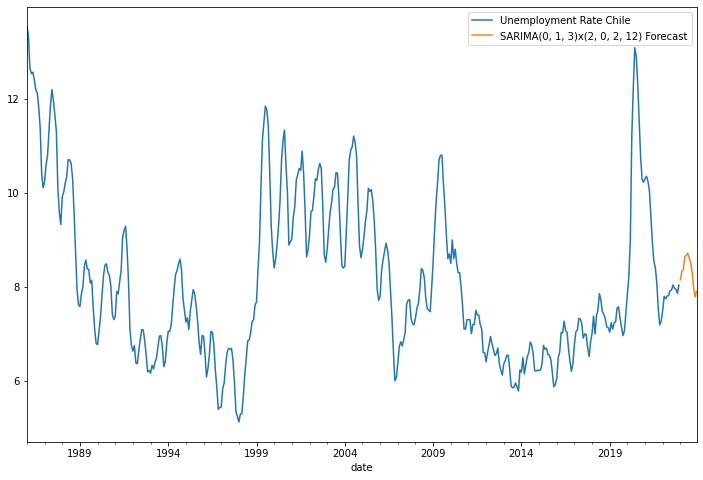

In [24]:
plt.figure(figsize = (12, 8))
df["Unemployment Rate Chile"].plot(legend = True)
y_forecast.plot(legend = True)

<AxesSubplot:xlabel='date'>

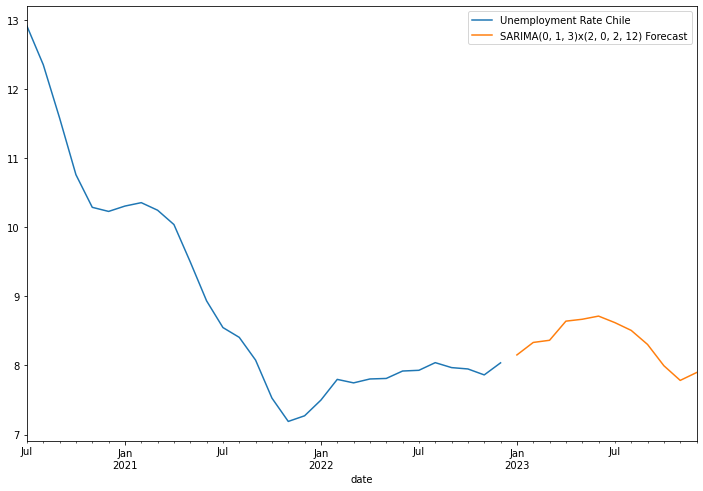

In [25]:
plt.figure(figsize = (12, 8))
df["Unemployment Rate Chile"].iloc[-30:].plot(legend = True)
y_forecast.plot(legend = True)

In [26]:
y_forecast

2023-01-01    8.151488
2023-02-01    8.332187
2023-03-01    8.363531
2023-04-01    8.640168
2023-05-01    8.667579
2023-06-01    8.713222
2023-07-01    8.618807
2023-08-01    8.506282
2023-09-01    8.303137
2023-10-01    7.995419
2023-11-01    7.783324
2023-12-01    7.896747
Freq: MS, Name: SARIMA(0, 1, 3)x(2, 0, 2, 12) Forecast, dtype: float64